In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential

2024-09-30 14:15:10.627589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 14:15:10.788534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 14:15:10.831680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 14:15:11.144257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 14:15:14.338596: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv('datos_Pablo_The_Good')

# Aquí simplemente eliminamos una antigua columna de índices 
df.drop(columns='Unnamed: 0', axis=1, inplace=True)

Tenemos este dataframe de introducción. Este dataframe está basado en los datos que utilizarás en el TFG pero simplificado. Estamos estudiando únicamente el caso de **consumo** para **un sólo cliente**. Vamos a estudiar cómo funcionan las series temporales para un sólo cliente para entender la distribución y estructuración de los datos que tenemos. En el TFG, tendrás este mismo dataset, con alguna columna más, y tendrás que estudiarlo para varios clientes (existirá una columna ***client_key*** que te indicará cuál es el cliente, pero nos olvidaremos de ella por ahora).

In [3]:
df[0:5]

target             datetime  installed_capacity  temperature   dewpoint  \
0    59.0  2021-09-01 00:00:00               400.0    13.825000  10.633333   
1    61.6  2021-09-01 01:00:00               400.0    13.600000  10.283333   
2    63.1  2021-09-01 02:00:00               400.0    13.158333  10.075000   
3    64.0  2021-09-01 03:00:00               400.0    12.816667   9.983333   
4    60.5  2021-09-01 04:00:00               400.0    12.591667  10.033333   

   rain  snowfall  cloudcover_total  shortwave_radiation  \
0   0.0       0.0         45.916667                  0.0   
1   0.0       0.0         24.833333                  0.0   
2   0.0       0.0         12.000000                  0.0   
3   0.0       0.0          9.166667                  0.0   
4   0.0       0.0          4.833333                  0.0   

   direct_solar_radiation  diffuse_radiation  
0                     0.0                0.0  
1                     0.0                0.0  
2                     0.0                0.0  
3                     0.0                0.0  
4                     0.0                0.0

Lo primero es entender el dataframe. Tenemos muchas columnas, pero nos centraremos en dos: **datetime** y **target**. Si observamos **datetime** con detenimiento, podemos ver que cada fila corresponde a un día y una hora, y que tenemos una fila por cada hora del día. 

In [4]:
df[0:25]

target             datetime  installed_capacity  temperature   dewpoint  \
0     59.0  2021-09-01 00:00:00               400.0    13.825000  10.633333   
1     61.6  2021-09-01 01:00:00               400.0    13.600000  10.283333   
2     63.1  2021-09-01 02:00:00               400.0    13.158333  10.075000   
3     64.0  2021-09-01 03:00:00               400.0    12.816667   9.983333   
4     60.5  2021-09-01 04:00:00               400.0    12.591667  10.033333   
5     65.0  2021-09-01 05:00:00               400.0    12.341667  10.050000   
6     55.3  2021-09-01 06:00:00               400.0    12.258333   9.958333   
7     67.8  2021-09-01 07:00:00               400.0    12.825000   9.891667   
8    118.9  2021-09-01 08:00:00               400.0    13.266667   9.333333   
9     87.2  2021-09-01 09:00:00               400.0    13.433333   9.316667   
10    52.2  2021-09-01 10:00:00               400.0    13.725000   8.766667   
11    28.5  2021-09-01 11:00:00               400.0    14.058333   8.200000   
12    30.0  2021-09-01 12:00:00               400.0    14.175000   7.458333   
13    30.7  2021-09-01 13:00:00               400.0    14.383333   7.033333   
14    62.8  2021-09-01 14:00:00               400.0    14.541667   6.433333   
15    71.8  2021-09-01 15:00:00               400.0    14.591667   5.816667   
16    69.8  2021-09-01 16:00:00               400.0    14.325000   5.325000   
17    48.0  2021-09-01 17:00:00               400.0    13.966667   5.391667   
18    51.0  2021-09-01 18:00:00               400.0    13.433333   5.333333   
19    47.4  2021-09-01 19:00:00               400.0    12.825000   5.133333   
20    59.1  2021-09-01 20:00:00               400.0    12.316667   5.250000   
21    75.8  2021-09-01 21:00:00               400.0    11.550000   5.600000   
22    80.6  2021-09-01 22:00:00               400.0    11.266667   5.766667   
23    81.9  2021-09-01 23:00:00               400.0    11.025000   5.791667   
24    75.8  2021-09-02 00:00:00               400.0    10.875000   5.875000   

        rain  snowfall  cloudcover_total  shortwave_radiation  \
0   0.000000       0.0         45.916667             0.000000   
1   0.000000       0.0         24.833333             0.000000   
2   0.000000       0.0         12.000000             0.000000   
3   0.000000       0.0          9.166667             0.000000   
4   0.000000       0.0          4.833333             0.000000   
5   0.000000       0.0         10.166667             0.000000   
6   0.000000       0.0         15.333333            10.416667   
7   0.000000       0.0         16.000000            82.083333   
8   0.000000       0.0         17.500000           191.333333   
9   0.000000       0.0         13.750000           313.416667   
10  0.000000       0.0         13.916667           397.416667   
11  0.000000       0.0         21.666667           480.166667   
12  0.000000       0.0         27.500000           512.416667   
13  0.000000       0.0         37.416667           513.750000   
14  0.000000       0.0         42.916667           494.333333   
15  0.016667       0.0         35.583333           405.166667   
16  0.000000       0.0         36.416667           304.666667   
17  0.016667       0.0         45.500000           226.750000   
18  0.016667       0.0         50.500000           123.666667   
19  0.025000       0.0         53.083333            46.000000   
20  0.008333       0.0         38.666667             1.666667   
21  0.033333       0.0         28.000000             0.000000   
22  0.000000       0.0         29.666667             0.000000   
23  0.000000       0.0         22.166667             0.000000   
24  0.000000       0.0         46.833333             0.000000   

    direct_solar_radiation  diffuse_radiation  
0                 0.000000           0.000000  
1                 0.000000           0.000000  
2                 0.000000           0.000000  
3                 0.000000           0.000000  
4                 

En realidad, el consumo eléctrico (columna **target**) probablemente tenga un comportamiento cíclico en función de las horas del día. Esto significa que nuestros datos podrían darnos más información si conseguimos agruparlos en **series temporales**, ya que así el modelo puede entender que están agrupadas y no tratarlos como filas sin relación. 

## Ejemplo simple de organización del dataframe para entrar en un modelo

Supongamos que quiero predecir el consumo eléctrico en las próximas 8 horas, y utilizaré una red LSTM. Lo primero que hay que hacer es separar las variables que entrarán en el modelo y la columna a predecir.

In [5]:
X = np.array(df.drop('target', axis=1))
y = np.array(df['target'])

In [6]:
print('X shape:', X.shape, '\n',
      'y shape:', y.shape)

X shape: (15275, 10) 
 y shape: (15275,)


Tenemos 15275 filas, 10 variables en la *X* y 1 sola variable en la *y*, esto nos da las dimensiones.

Vamos a establecer dos variables:
-  **sequence**, que nos indica la longitud de la serie temporal en la X: en nuestro caso siempre va a ser 24 porque la serie que nos interesa son **las 24 horas del día** (como tenemos 1 fila por hora -> 24 filas)
- **forecast_horizon**: esta variable nos indica el numero de pasos que queremos predecir en el futuro, es decir, si quiero predecir el consumo de un día entero, forecast_horizon = 24. Si sólo quiero predecir 3h, forecast_horizon = 3.

En nuestro caso, **lead_time** es 0 porque queremos las horas siguientes a las últimas que tenemos

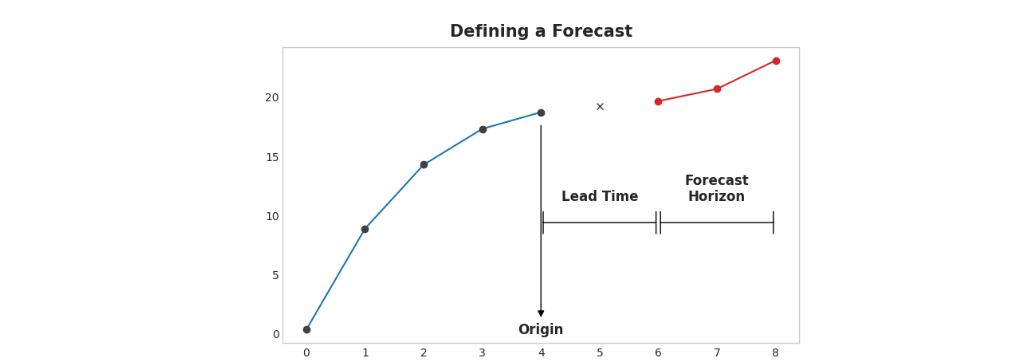

In [7]:
sequence = 24
feature_target = 8  # Predecimos 8 h

Tenemos que excluir la columna *datetime* de la X antes de introducirla al modelo, y en el caso del TFG tendrás más variables que sacar del dataframe. Para ello introducimos la variable **features_columns** y seleccionamos con ella las columnas que queremos introducir en la X:

In [8]:
features_columns = ['installed_capacity', 'temperature', 'dewpoint',
       'rain', 'snowfall', 'cloudcover_total', 'shortwave_radiation',
       'direct_solar_radiation', 'diffuse_radiation']

target_column = 'target'

In [9]:
def create_sequences_single_client(df, features_columns, target_column, sequence, feature_target):
    X_seq, y_seq = [], []
    
    # Extraer las características y el target
    X_client = df[features_columns].values  # Todas las columnas de características
    y_client = df[target_column].values     # La columna target (e.g., consumo)

    # Crear las secuencias temporales de características (X) y los valores de predicción (y)
    for i in range(len(X_client) - sequence - feature_target):
        # Ventana de características
        X_seq.append(X_client[i:i + sequence])
        # Valores a predecir (puede ser más de uno, de acuerdo a feature_target)
        y_seq.append(y_client[i + sequence:i + sequence + feature_target])

    # Convertir listas a numpy arrays
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    return X_seq, y_seq

In [10]:
X_seq, y_seq = create_sequences_single_client(df=df, features_columns=features_columns, target_column=target_column, sequence=sequence, feature_target=feature_target)

In [11]:
print('X shape:', X_seq.shape, '\n',
      'y shape:', y_seq.shape)

X shape: (15243, 24, 9) 
 y shape: (15243, 8)


Ahora en las dimensiones de las *X* tenemos: (filas, 24 de longitud de secuencia, 9 variables (hemos excluido la columna 'datetime'))

En las dimensiones de la *y*: (filas, 8 de longitud de secuencia)

Esto significa que una fila de la X (en total tendremos 15243 filas) es un elemento de dos dimensiones, que a su vez tiene 24 filas con 9 variables en cada una.  
Es decir, cada fila es una serie temporal. Veamos la primera fila:

In [12]:
print(X_seq[0].shape)
print(X_seq[0])

(24, 9)
[[4.00000000e+02 1.38250000e+01 1.06333333e+01 0.00000000e+00
  0.00000000e+00 4.59166667e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.00000000e+02 1.36000000e+01 1.02833333e+01 0.00000000e+00
  0.00000000e+00 2.48333333e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.00000000e+02 1.31583333e+01 1.00750000e+01 0.00000000e+00
  0.00000000e+00 1.20000000e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.00000000e+02 1.28166667e+01 9.98333333e+00 0.00000000e+00
  0.00000000e+00 9.16666667e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.00000000e+02 1.25916667e+01 1.00333333e+01 0.00000000e+00
  0.00000000e+00 4.83333333e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.00000000e+02 1.23416667e+01 1.00500000e+01 0.00000000e+00
  0.00000000e+00 1.01666667e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.00000000e+02 1.22583333e+01 9.95833333e+00 0.00000000e+00
  0.00000000e+00 1.53333333e+01 1.04166667e+01 3.83333333e+00
  6.58333333e+00

A su vez, la *y* tendrá 15243 filas, y cada fila será un elemento de longitud 8 (el total de horas que queremos predecir):

In [13]:
y_seq

array([[  75.8  ,   76.3  ,   74.   , ...,   77.9  ,   71.2  ,   82.1  ],
       [  76.3  ,   74.   ,   77.9  , ...,   71.2  ,   82.1  ,  125.9  ],
       [  74.   ,   77.9  ,   76.5  , ...,   82.1  ,  125.9  ,   66.   ],
       ...,
       [ 478.384,  461.716,  456.556, ...,  478.478,  544.674,  728.564],
       [ 461.716,  456.556,  460.573, ...,  544.674,  728.564,  802.283],
       [ 456.556,  460.573,  434.038, ...,  728.564,  802.283, 1059.843]])

## Separación de datasets para entrenamiento

Ahora, tenemos que escalar los datos y dividir en train, test y val antes de generar las secuencias para organizar los datos correctamente.

In [14]:
def create_sequences_scaled(df, features_columns, target_column, sequence, feature_target, train_size=0.7, val_size=0.15, has_scale=True):
    # Extraer las características y el target
    X_client = df[features_columns].values  # Todas las columnas de características
    y_client = df[target_column].values     # La columna target (e.g., consumo)

    # Dividir el conjunto de datos antes de escalar
    train_index = int(len(X_client) * train_size)
    val_index = train_index + int(len(X_client) * val_size)

    # Dividir en conjunto de entrenamiento, validación y prueba
    X_train, X_val, X_test = X_client[:train_index], X_client[train_index:val_index], X_client[val_index:]
    y_train, y_val, y_test = y_client[:train_index], y_client[train_index:val_index], y_client[val_index:]

    # Escalar los datos si es necesario
    if has_scale:
        # Crear escaladores para X y y
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        # Ajustar el escalador en el conjunto de entrenamiento
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)

        # Aplicar el escalador en el conjunto de validación y prueba
        X_val_scaled = scaler_X.transform(X_val)
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(-1)

        X_test_scaled = scaler_X.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)
    else:
        # Si no se requiere escalado, mantener los datos originales
        X_train_scaled, y_train_scaled = X_train, y_train
        X_val_scaled, y_val_scaled = X_val, y_val
        X_test_scaled, y_test_scaled = X_test, y_test

    # Crear las secuencias a partir de los datos escalados
    def create_sequences(X, y, sequence, feature_target):
        X_seq, y_seq = [], []
        for i in range(len(X) - sequence - feature_target):
            X_seq.append(X[i:i + sequence])
            y_seq.append(y[i + sequence:i + sequence + feature_target])
        return np.array(X_seq), np.array(y_seq)

    # Crear las secuencias temporales para cada conjunto
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence, feature_target)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, sequence, feature_target)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence, feature_target)

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, scaler_y

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler_y = create_sequences_scaled(df=df, features_columns=features_columns, target_column=target_column, sequence=sequence, feature_target=feature_target)

## Entrenamiento

In [16]:
num_epochs = 100
batch_size = 64
input_shape = X_seq.shape[-2:] # Seleccionamos las 2 ultimas dimensiones (tamaño secuencia, nº features) -> dimensión de cada fila
print(input_shape)

(24, 9)


In [17]:
neuronas = 64

tf.keras.backend.clear_session()

#Modelo
lstm_model = Sequential([
    Input(shape = input_shape),
    LSTM(neuronas, return_sequences=False),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(feature_target)
])

In [18]:
loss = tf.keras.losses.MeanSquaredError() #MSE
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)
metric = [tf.keras.metrics.RootMeanSquaredError()]

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)  

In [19]:
lstm_model.compile(loss = loss, optimizer=optimizer, metrics = metric)

history = lstm_model.fit(
    X_train,  
    y_train,  
    epochs=num_epochs,  # Número de épocas
    validation_data=(X_val, y_val),  # Datos de validación (X_val e y_val)
    callbacks=[early_stopping],  
    batch_size=batch_size  # Tamaño del batch
)

Epoch 1/100

167/167 [==============================] - 3s 8ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941
Epoch 2/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0657 - val_root_mean_squared_error: 0.2563
Epoch 3/100
167/167 [==============================] - 1s 6ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2382
Epoch 4/100
167/167 [==============================] - 1s 6ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2388
Epoch 5/100
167/167 [==============================] - 1s 6ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 6/100
167/167 [==============================] - 1s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0421

## Graficar pérdida

In [20]:
# Extraer los valores de la pérdida y la pérdida de validación desde el historial
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un rango para las épocas
epochs = range(1, len(loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')  # 'b' es el color azul
plt.plot(epochs, val_loss, 'r', label='Pérdida de validación')  # 'r' es el color rojo
plt.title('Pérdida durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar la gráfica
plt.show()

## Obtener predicciones y calcular métricas

In [21]:
train_pred = lstm_model.predict(X_train)
test_pred = lstm_model.predict(X_test)
val_pred = lstm_model.predict(X_val)

print(train_pred.shape, test_pred.shape, val_pred.shape)

71/71 [==============================] - 0s 2ms/step
(10660, 8) (2260, 8) (2259, 8)


In [22]:
# Desescalar los valores reales y las predicciones usando el escalador ajustado en el entrenamiento
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
test_pred_original = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1)

In [23]:
# Calcular las métricas en la escala original
mae_test = mean_absolute_error(y_test_original, test_pred_original)
mse_test = mean_squared_error(y_test_original, test_pred_original)
r2_test = r2_score(y_test_original, test_pred_original)
error_percentage = mae_test / (y_test_original.mean()) * 100

print(f"MAE (Mean Absolute Error): {mae_test}")
print(f"Error Percentage: {error_percentage} %")
print(f"MSE (Mean Squared Error): {mse_test}")
print(f"R²: {r2_test}")

MAE (Mean Absolute Error): 591.5278291493848
Error Percentage: 77.001579061519 %
MSE (Mean Squared Error): 547478.382712129
R²: -4.683532608004948
